# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08


# NOTAS PROF
- DETETAR E EXCLUIR OUTLIERS DOS CLUSTERS PEQUENOS 
- ADICIONAR DENDROGRAMA DOS CLUSTERS
- EXPERIMENTAR DBSCAN
- ADICIONAR E VALIDAR CENTROIDES

# File and libraries

In [74]:
import pandas as pd
import numpy as np


filepath=r'/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/non_supervised_analysis/notebooks/dataset_2/df_bakery_encoded.csv'

file_tag = "Bakery Pattern Mining"

data = pd.read_csv(filepath)


In [75]:
%run "scripts/dslabs_functions.py"

In [76]:
%run "scripts/data_functions.py"

data_functions lodaded


In [77]:
data_copy=data.copy()
data_copy = data_copy.dropna(axis=0, how="any") #axis=0 tells dropna to remove rows that have at least one NaN value.

# Clustering

In [78]:
from sklearn import cluster
from sklearn.metrics import pairwise_distances

In [79]:
def mydistance(x1, x2):
    res = 0
    fix_weight = 1
    for j in range(len(x1)):
        res += fix_weight*abs(x1[j]-x2[j])
    return res

def affinity(X):
    return pairwise_distances(X, metric=mydistance)

In [80]:
hier_algo = cluster.AgglomerativeClustering(n_clusters=5, metric=affinity, linkage='complete')
hier_model = hier_algo.fit(data_copy)
hier_model.labels_

array([1, 1, 2, ..., 1, 1, 1])

In [81]:
from sklearn import metrics
print("Silhouette:",metrics.silhouette_score(data_copy, hier_model.labels_))

Silhouette: 0.74831119558551


In [82]:
data_copy['cluster']=hier_model.labels_


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns


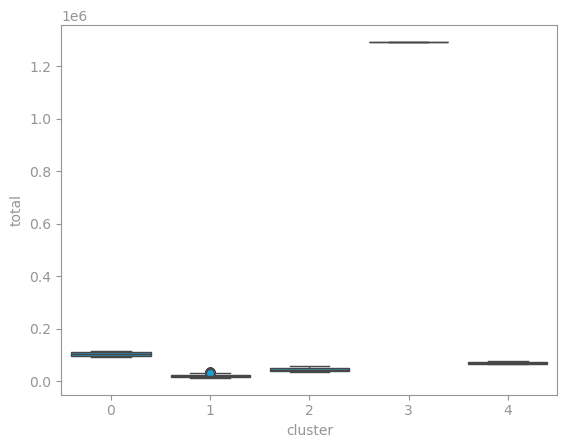

In [84]:
sns.boxplot(x="cluster", y='total', data=data_copy)      
plt.show()

## K Means

In [85]:
# Clustering

from sklearn import cluster, mixture
kmeans_algo = cluster.KMeans(n_clusters=3, random_state=1)
kmeans_model = kmeans_algo.fit(data_copy)

In [86]:
feature_names = feature_names = data_copy.columns.tolist()


In [87]:
# describe centroids

centroids = kmeans_model.cluster_centers_
centroid_df = pd.DataFrame(data=centroids, columns=feature_names)
print(centroid_df)

          total  angbutter  plain bread       jam  americano  croissant  \
0  1.825116e+04   1.138031     0.391892  0.095077   0.188707   0.361486   
1  1.293000e+06   6.000000     5.000000  0.000000   0.000000   5.000000   
2  3.495130e+04   2.492795     0.608069  0.149856   0.351585   0.850144   

   caffe latte  tiramisu croissant  cacao deep  pain au chocolat  ...  \
0     0.082529            0.335907    0.143340          0.258687  ...   
1     0.000000            0.000000    0.000000          5.000000  ...   
2     0.123919            0.717579    0.193084          0.533141  ...   

   hour_cos   min_sin   min_cos  day_of_month_sin  day_of_month_cos  \
0 -0.861576  0.075113  0.043259         -0.012735          0.003295   
1 -0.991000 -0.638000 -0.770000         -0.849000          0.529000   
2 -0.875398  0.111781  0.058625         -0.042285          0.021715   

   day_of_week_nr_sin  day_of_week_nr_cos  week_of_month_sin  \
0           -0.157986            0.168436           0.088

In [88]:
# show the clusters per instance
kmeans_model.labels_

array([0, 0, 2, ..., 0, 0, 0], dtype=int32)

## Customized distance using agglomerative clustering

In [89]:
from sklearn.metrics import pairwise_distances

def mydistance(x1, x2):
    res = 0.0001
    for j, weight in enumerate([1,2,3,1]):
        res += weight*abs(x1[j]-x2[j])
    return res

def sim_affinity(X):
    return pairwise_distances(X, metric=mydistance)


In [90]:
hier_algo = cluster.AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
hier_model = hier_algo.fit(data_copy)
hier_model.labels_


array([0, 0, 0, ..., 0, 0, 0])

## Evaluating the clustering solution using internal indices



In [91]:
from sklearn import metrics
y_pred = kmeans_model.labels_
print("Silhouette:",metrics.silhouette_score(data_copy, y_pred))
print("Silhouette per instance:\n",metrics.silhouette_samples(data_copy, y_pred)[:5],"...")
print("Sum of squared distances:",kmeans_model.inertia_)


Silhouette: 0.7006085605777561
Silhouette per instance:
 [0.48101275 0.84371167 0.39126744 0.82414381 0.84097135] ...
Sum of squared distances: 62018680949.56879


# Hierarchical clustering with different linkage criteria


## agglomerative clustering with different criteria



In [73]:
import time, warnings
from itertools import cycle, islice
from sklearn.preprocessing import StandardScaler

default_base = {'n_neighbors': 10,'n_clusters': 3}
datasets = [
    (data_copy, {'n_clusters': 2}),
    (data_copy, {'n_neighbors': 2}),
]

algorithms = {}
all_predictions = []
all_efficiency = []

for i_dataset, (dataset, algo_params) in enumerate(datasets):

    # 1a Set parameters for each dataset
    params = default_base.copy()
    params.update(algo_params)
    
    # 1b Parameterize clustering algorithms
    algorithms['Ward Linkage'] = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    algorithms['Complete Linkage'] = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    algorithms['Average Linkage'] = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    algorithms['Single Linkage'] = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    # 2 Access and normalize data
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # 3 Run clustering algorithm and store predictions
    predictions = {}
    efficiency = {}
    for name in algorithms:
        clustering = algorithms[name]
        t0 = time.time()
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the connectivity matrix is [0-9]{1,2}" +
                    " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            clustering.fit(X)
        efficiency[name]= time.time()-t0
        if hasattr(clustering, 'labels_'): predictions[name] = clustering.labels_.astype(np.int)
        else: predictions[name] = clustering.predict(X)
            
    all_predictions.append(predictions)
    all_efficiency.append(efficiency)

ValueError: too many values to unpack (expected 2)

## Plotting clustering solutions



In [ ]:
# Set up cluster parameters
plt.figure(figsize=(7, 6))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
plot_num = 1
for k in range(len(datasets)):
    predictions = all_predictions[k]
    efficiency = all_efficiency[k]
    X, y = datasets[k][0]
    X = StandardScaler().fit_transform(X)
    
    for name in predictions:
        y_pred = predictions[name]
        plt.subplot(len(datasets), len(algorithms), plot_num)
        if k == 0: plt.title(name, size=10)
        colors = np.array(list(islice(cycle(color_array),int(max(y_pred) + 1))))
        colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % efficiency[name]).lstrip('0'),
                 transform=plt.gca().transAxes,size=15,horizontalalignment='right')
        plot_num += 1

plt.show()


# Others: spectral, agglomerative, dbscan, model-based


Applying different clustering algorithms available in sklearn to the previously generated data
